# Using Time Series to Model Spotify Streaming Data

### [Data_Prep](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#Data-Preparation)
### [Plotting TS](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#Plotting-Time-Series-Data)
### [Plotting #1 Song Streams](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#Plotting-#-of-Streams-for-#1-Song-for-different-Regions)
### [Creating Stationary TS Data](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#Creating-Stationary-TimeSeries-Data)
### [Seasonal Decompostion](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#Using-Seasonal-Decomposition-to-Increase-Stationariness-of-Data)
### [ARIMA](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#ARIMA-models)
### [Conclusions & Future Directions](http://localhost:8888/notebooks/Spotify_Time_Series.ipynb#Conclusions-&-Future-Directions)
##### Refrences
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
import datetime
from dateutil.relativedelta import relativedelta
plt.style.use('ggplot')
%matplotlib inline

/Users/gmgtex/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# function to create bigger fonts
def bigger_fonts(ax):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Data Preparation

In [3]:
#Read in spotify data
spotify_df = pd.read_csv('../data/data.csv', infer_datetime_format=True, parse_dates=['Date'])

In [36]:
# create day of week and day column
spotify_df['day_of_week'] = spotify_df['Date'].dt.dayofweek
spotify_df['day'] = spotify_df['day_of_week'].map({0:'Monday',1:'Tuesday',\
                                                     2:'Wednesday',3:'Thursday',\
                                                     4:'Friday',5:'Saturday',6:'Sunday'})
spotify_df.head()

Position                  Track Name        Artist  Streams  \
0         1                    Chantaje       Shakira   253019   
1         2                Vente Pa' Ca  Ricky Martin   223988   
2         3  Reggaetón Lento (Bailemos)          CNCO   210943   
3         4                      Safari      J Balvin   173865   
4         5                 Shaky Shaky  Daddy Yankee   153956   

                                                 URL       Date Region  \
0  https://open.spotify.com/track/6mICuAdrwEjh6Y6... 2017-01-01     ar   
1  https://open.spotify.com/track/7DM4BPaS7uofFul... 2017-01-01     ar   
2  https://open.spotify.com/track/3AEZUABDXNtecAO... 2017-01-01     ar   
3  https://open.spotify.com/track/6rQSrBHf7HlZjtc... 2017-01-01     ar   
4  https://open.spotify.com/track/58IL315gMSTD37D... 2017-01-01     ar   

   day_of_week     day  
0            6  Sunday  
1            6  Sunday  
2            6  Sunday  
3            6  Sunday  
4            6  Sunday

In [5]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017625 entries, 0 to 2017624
Data columns (total 9 columns):
Position       int64
Track Name     object
Artist         object
Streams        int64
URL            object
Date           datetime64[ns]
Region         object
day_of_week    int64
day            object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 138.5+ MB


In [6]:
spotify_df.describe()

Position       Streams   day_of_week
count  2.017625e+06  2.017625e+06  2.017625e+06
mean   9.394797e+01  5.208577e+04  2.993814e+00
std    5.735935e+01  2.095484e+05  2.002716e+00
min    1.000000e+00  1.001000e+03  0.000000e+00
25%    4.400000e+01  3.189000e+03  1.000000e+00
50%    9.100000e+01  8.674000e+03  3.000000e+00
75%    1.420000e+02  2.814300e+04  5.000000e+00
max    2.000000e+02  1.138152e+07  6.000000e+00

In [7]:
# create df with songs that were #1 (top of the charts)
top_o_charts = spotify_df[spotify_df['Position'] == 1]
songs_that_topped = set((top_o_charts['Track Name'].tolist()))
print(songs_that_topped)
print(len(songs_that_topped))
region_charts = top_o_charts[['Date','Region','Streams','Artist','Track Name', 'day_of_week','day']].reset_index()
print(len(region_charts))
region_charts.head()

{nan, 'Eikö Sua Hävetä', 'Hanuri (feat. Boyat)', 'Ahora Dice', 'Rockabye (feat. Sean Paul & Anne-Marie)', 'Rica', '4x Duurder', 'All I Need', 'Line', 'El Farsante', 'Krantenwijk', 'Wild Thoughts', 'Happy Days', 'Galway Girl', 'Chantaje', 'Utro', 'I Can´t Go On', 'Mä hiihdän', 'Hear Me Now', 'Helt seriöst', 'Una Lady Como Tú', 'New Rules', 'Pettävällä Jäällä - Vain Elämää Kausi 6', 'Robarte un Beso', 'Without You (feat. Sandro Cavazza)', 'Lamborghini', 'Akad', 'Heavy (feat. Kiiara)', 'De Snakker', 'Vai Embrazando', "It Ain't Me (with Selena Gomez)", 'More Than You Know', 'Dexter', 'In The End', 'Thunder', 'Α. Nwaar Is The New Black', 'Shape of You', 'Lapioin', 'Tran Tran', 'Salam', 'EYO (feat. Nelli Matula)', 'Ked Af Det', 'Hukutaan', 'Paris', 'Escápate Conmigo', 'Olha a Explosão', 'Yhtäccii', 'Sua Cara (feat. Anitta & Pabllo Vittar)', 'Passionfruit', 'Paradinha', 'Juna', 'Fy faen', 'Helwa', 'There for You', 'XO TOUR Llif3', 'Soy Peor', 'Despacito (Featuring Daddy Yankee)', 'Caramelle',

index       Date Region  Streams   Artist Track Name  day_of_week  \
0      0 2017-01-01     ar   253019  Shakira   Chantaje            6   
1    200 2017-01-02     ar   185399  Shakira   Chantaje            0   
2    400 2017-01-03     ar   183132  Shakira   Chantaje            1   
3    600 2017-01-04     ar   186926  Shakira   Chantaje            2   
4    800 2017-01-05     ar   191288  Shakira   Chantaje            3   

         day  
0     Sunday  
1     Monday  
2    Tuesday  
3  Wednesday  
4   Thursday

In [8]:
# avg number of streams per day
avg_streams = spotify_df.groupby(['Region','Date'])['Region','Streams'].mean().reset_index()
avg_streams.rename(columns={'Streams':'avg_streams'}, inplace=True)
print(len(avg_streams))
avg_streams.head()

11854


Region       Date  avg_streams
0     ar 2017-01-01    39444.360
1     ar 2017-01-02    30050.205
2     ar 2017-01-03    29609.535
3     ar 2017-01-04    30097.865
4     ar 2017-01-05    31118.230

In [9]:
# merging avg number of streams per day and top of the charts df
streaming_data = region_charts.merge(avg_streams, on=('Date', 'Region'), how='left')
streaming_data.rename(columns={'Streams':'Streams_#1_song'}, inplace=True)
streaming_data.head()

index       Date Region  Streams_#1_song   Artist Track Name  day_of_week  \
0      0 2017-01-01     ar           253019  Shakira   Chantaje            6   
1    200 2017-01-02     ar           185399  Shakira   Chantaje            0   
2    400 2017-01-03     ar           183132  Shakira   Chantaje            1   
3    600 2017-01-04     ar           186926  Shakira   Chantaje            2   
4    800 2017-01-05     ar           191288  Shakira   Chantaje            3   

         day  avg_streams  
0     Sunday    39444.360  
1     Monday    30050.205  
2    Tuesday    29609.535  
3  Wednesday    30097.865  
4   Thursday    31118.230

# Plotting Time Series Data

In [10]:
spotify_df_no_global = spotify_df[spotify_df['Region']!='global']
avg_region_streams = spotify_df_no_global.groupby('Region').mean().reset_index()
ax = avg_region_streams.plot.barh(x='Region', y=['Streams'],figsize=(20,20), title = 'Avg Daily Streams per Region')
bigger_fonts(ax)
plt.savefig('../images/Avg_Streams_per_Region.png')

In [11]:
# pulling global streaming data
global_streaming_data = streaming_data[streaming_data['Region'] == 'global']
global_streaming_data.head()

index       Date  Region  Streams_#1_song      Artist Track Name  \
4629  822764 2017-01-01  global          3135625  The Weeknd    Starboy   
4630  822964 2017-01-02  global          3342769  The Weeknd    Starboy   
4631  823164 2017-01-03  global          3563076  The Weeknd    Starboy   
4632  823364 2017-01-04  global          3619247  The Weeknd    Starboy   
4633  823564 2017-01-05  global          3579206  The Weeknd    Starboy   

      day_of_week        day  avg_streams  
4629            6     Sunday   743065.835  
4630            0     Monday   774054.180  
4631            1    Tuesday   831199.650  
4632            2  Wednesday   846262.535  
4633            3   Thursday   849595.470

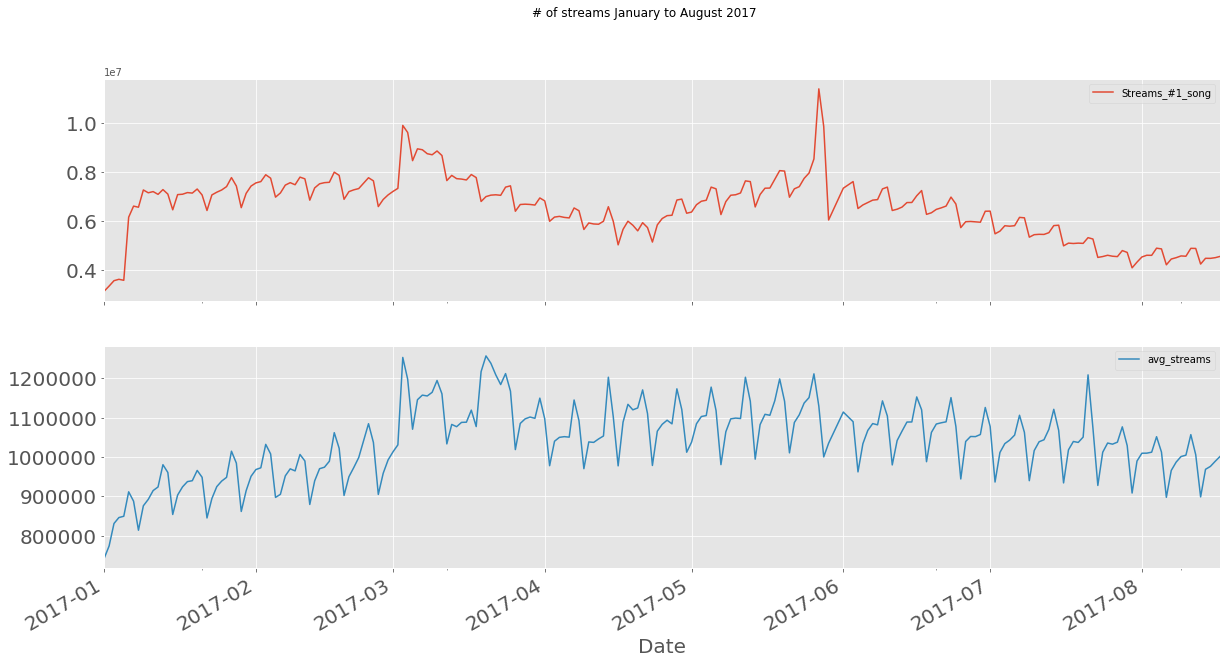

In [14]:
#Plotting streaming data
ax1, ax2 = global_streaming_data.plot(kind='line',x='Date', \
                                y=['Streams_#1_song', 'avg_streams'], figsize=(20,10),\
                                title='# of streams January to August 2017', subplots=True)
bigger_fonts(ax1)
bigger_fonts(ax2)
plt.savefig('../images/Jan_avg_streams_v.s_streams_#1_song.png')

### We see an increase in streams in March which coincides with Spring Break. Which varies but typically falls in the month of March.

In [38]:
#Removing #1 song
no_num_1_song = spotify_df[spotify_df['Position'] != 1]
# print(no_num_1_song.head())
total_streams_wno_top_song = no_num_1_song.groupby(['Region', 'Date'])['Streams'].sum().reset_index()
avg_streams_wno_top_song = no_num_1_song.groupby(['Region','Date'])['Streams'].mean().reset_index()

avg_streaming_plot = avg_streams.merge(avg_streams_wno_top_song, on=('Date', 'Region'), how='left')
avg_streaming_plot.rename(columns={'Streams':'avg_streams_without_top_song', 'avg_streams':'avg_streams_w_top_song'}, inplace=True)
avg_streaming_global_plot = avg_streaming_plot[avg_streaming_plot['Region'] == 'global']
print(avg_streaming_global_plot.head())
ax1, ax2 = avg_streaming_global_plot.plot(kind='line',x='Date', \
                                y=['avg_streams_w_top_song','avg_streams_without_top_song'], figsize=(20,10),\
                                title='# of streams January to August 2017 with and without top song', subplots=True)
bigger_fonts(ax1)
bigger_fonts(ax2)
plt.savefig('../images/total_streams_with_top_song_removed.png')

      Region       Date  avg_streams_w_top_song  avg_streams_without_top_song
4629  global 2017-01-01              743065.835                 731042.924623
4630  global 2017-01-02              774054.180                 761146.065327
4631  global 2017-01-03              831199.650                 817471.628141
4632  global 2017-01-04              846262.535                 832327.939698
4633  global 2017-01-05              849595.470                 835878.834171


### Still see similar trend when number of streams for the top song is removed so the top song of the day does not necessarily drive the overall trend for number of streams per day

In [20]:
#getting streaming data for Januray
jan_data = global_streaming_data[global_streaming_data['Date'] <= '2017-02-01']
jan_data.head(10)

index       Date  Region  Streams_#1_song      Artist    Track Name  \
4629  822764 2017-01-01  global          3135625  The Weeknd       Starboy   
4630  822964 2017-01-02  global          3342769  The Weeknd       Starboy   
4631  823164 2017-01-03  global          3563076  The Weeknd       Starboy   
4632  823364 2017-01-04  global          3619247  The Weeknd       Starboy   
4633  823564 2017-01-05  global          3579206  The Weeknd       Starboy   
4634  823764 2017-01-06  global          6151345  Ed Sheeran  Shape of You   
4635  823964 2017-01-07  global          6602494  Ed Sheeran  Shape of You   
4636  824164 2017-01-08  global          6557531  Ed Sheeran  Shape of You   
4637  824364 2017-01-09  global          7261007  Ed Sheeran  Shape of You   
4638  824564 2017-01-10  global          7145757  Ed Sheeran  Shape of You   

      day_of_week        day  avg_streams  
4629            6     Sunday   743065.835  
4630            0     Monday   774054.180  
4631            1    Tuesday   831199.650  
4632            2  Wednesday   846262.535  
4633            3   Thursday   849595.470  
4634            4     Friday   911607.935  
4635            5   Saturday   887835.120  
4636            6     Sunday   814157.455  
4637            0     Monday   876179.295  
4638            1    Tuesday   892404.280

### Looks like # of Streams is cyclical based on Day of Week

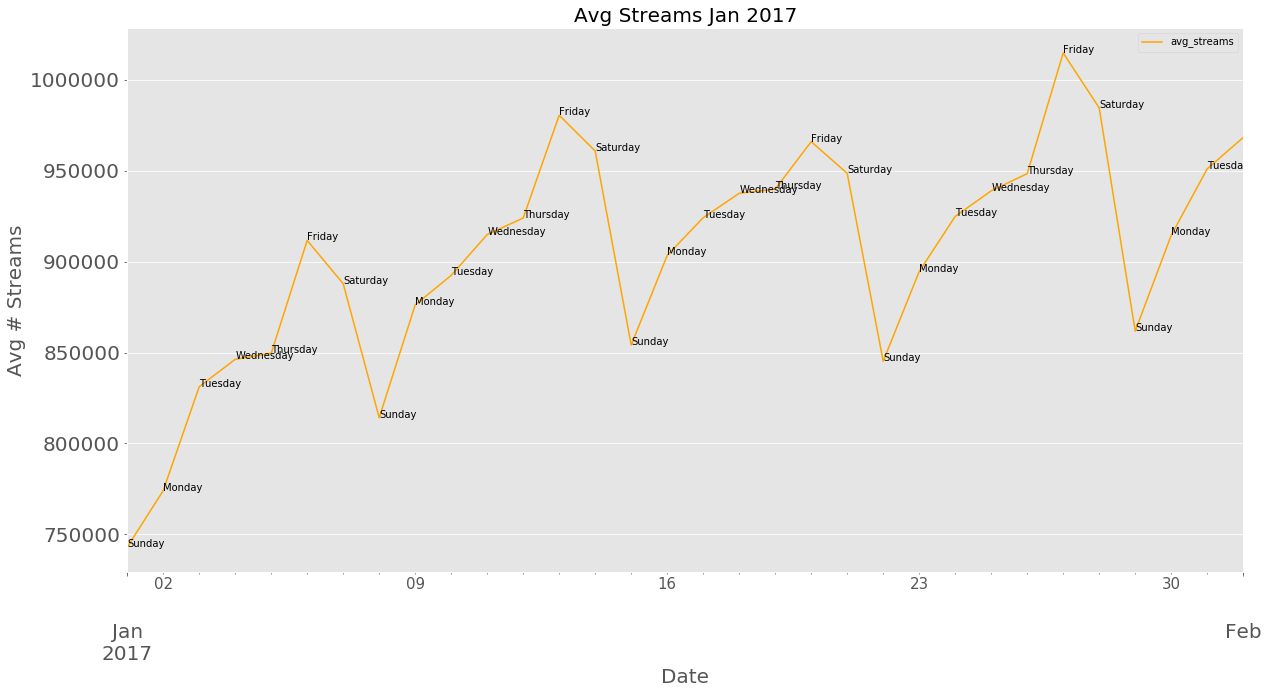

In [21]:
#plotting januray avg_streaming data
ax = jan_data.plot(kind='line',x='Date', y=['avg_streams'], \
                    figsize=(20,10), \
                    title='Avg Streams Jan 2017',\
                    color='orange', fontsize=15)
#increasing font size of plot
bigger_fonts(ax)

# Label points with day of week
date = jan_data['Date'].tolist()
avg_streams = jan_data['avg_streams'].tolist()
day = jan_data['day'].tolist()
for d, i, j in zip(day, date, avg_streams):
    ax.annotate(d, xy=(i,j),clip_on=True)
plt.ylabel('Avg # Streams')

#dataframe januray avg_streams
# global_streaming_data[['Date','avg_streams','day_of_week']]
plt.savefig('../images/Avg_Streaming_Jan_2017.png')

## Streaming increases everyday of the week peaking on Friday and drops significantly on Sundays

day_of_week        day       Streams
0            0     Monday  51114.237236
1            1    Tuesday  51762.966347
2            2  Wednesday  52362.444005
3            3   Thursday  51800.786690
4            4     Friday  55138.074701
5            5   Saturday  53917.110096
6            6     Sunday  48609.954158

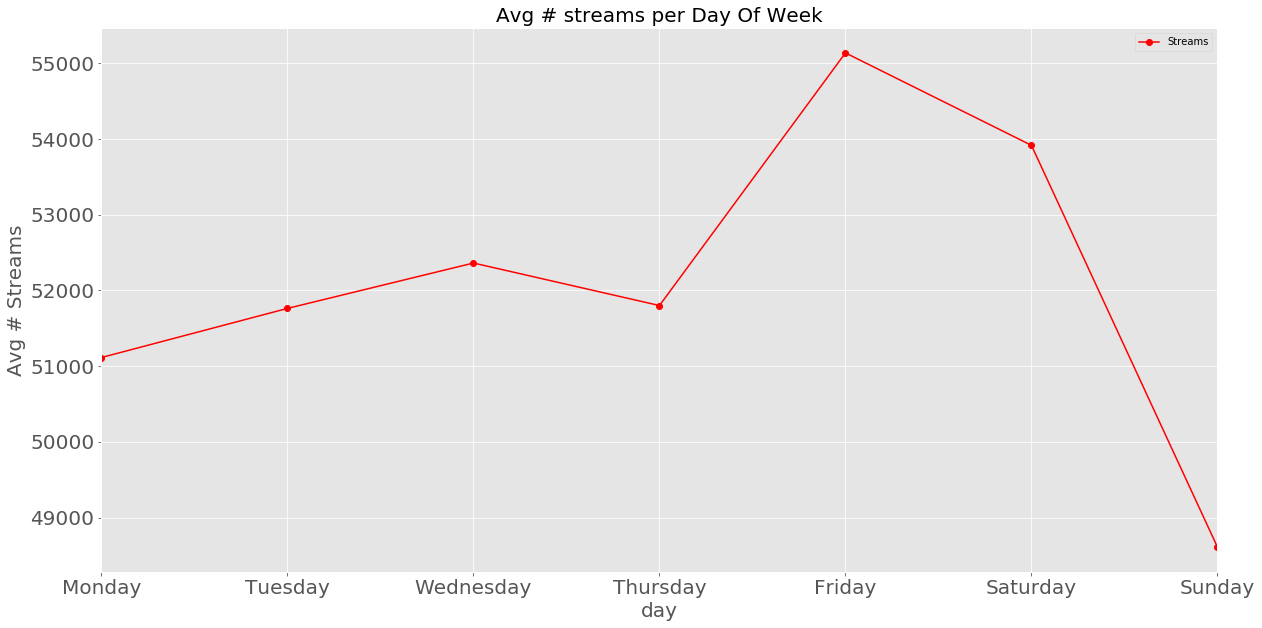

In [22]:
dow = spotify_df.groupby(['day_of_week','day']).mean()['Streams'].reset_index()

#plotting avg_streams per day of week
ax = dow.plot(x='day', y='Streams', figsize=(20,10), marker='o',title='Avg # streams per Day Of Week', color='red')
plt.ylabel('Avg # Streams')
bigger_fonts(ax)
plt.savefig('../images/Avg_Streaming_Day_of_Week.png')
dow

# Plotting # of Streams for #1 Song for different Regions

In [29]:
#Plotting top streams colored by #1 trackname
def plot_1_song(df, title):
    fig, ax = plt.subplots(1)
    for track in set(df['Track Name'].tolist()):
        df[df['Track Name'] == track].plot(ax=ax, x='Date', \
                                                y=['Streams_#1_song'], figsize=(20,15),\
                                                title=title,\
                                                color=np.random.rand(3,1).T)
        plt.ylabel('Total # Streams')
        plt.legend(set(df['Track Name'].tolist()))
        bigger_fonts(ax)

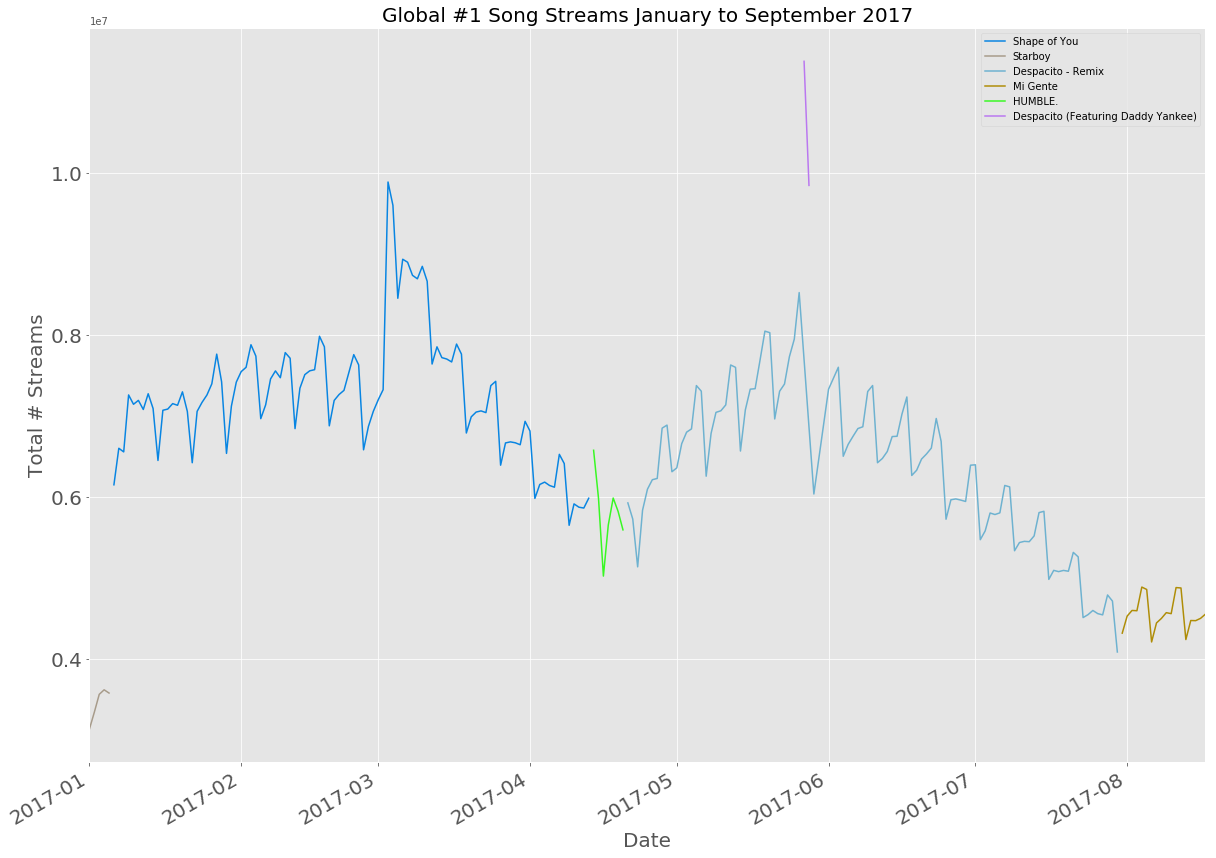

In [31]:
plot_1_song(global_streaming_data, 'Global #1 Song Streams January to September 2017')
plt.savefig('../images/Global_#1_Song_Streams_January_to_September_2017.png')

In [25]:
streaming_data.to_json('/Users/gmgtex/Documents/My Tableau Repository/DataSources/spotify_streaming.json')

In [26]:
def get_me_this_region(df, column_name, region_name):
    return df[df[column_name]==region_name]

In [27]:
us_data = get_me_this_region(streaming_data, 'Region', 'us')

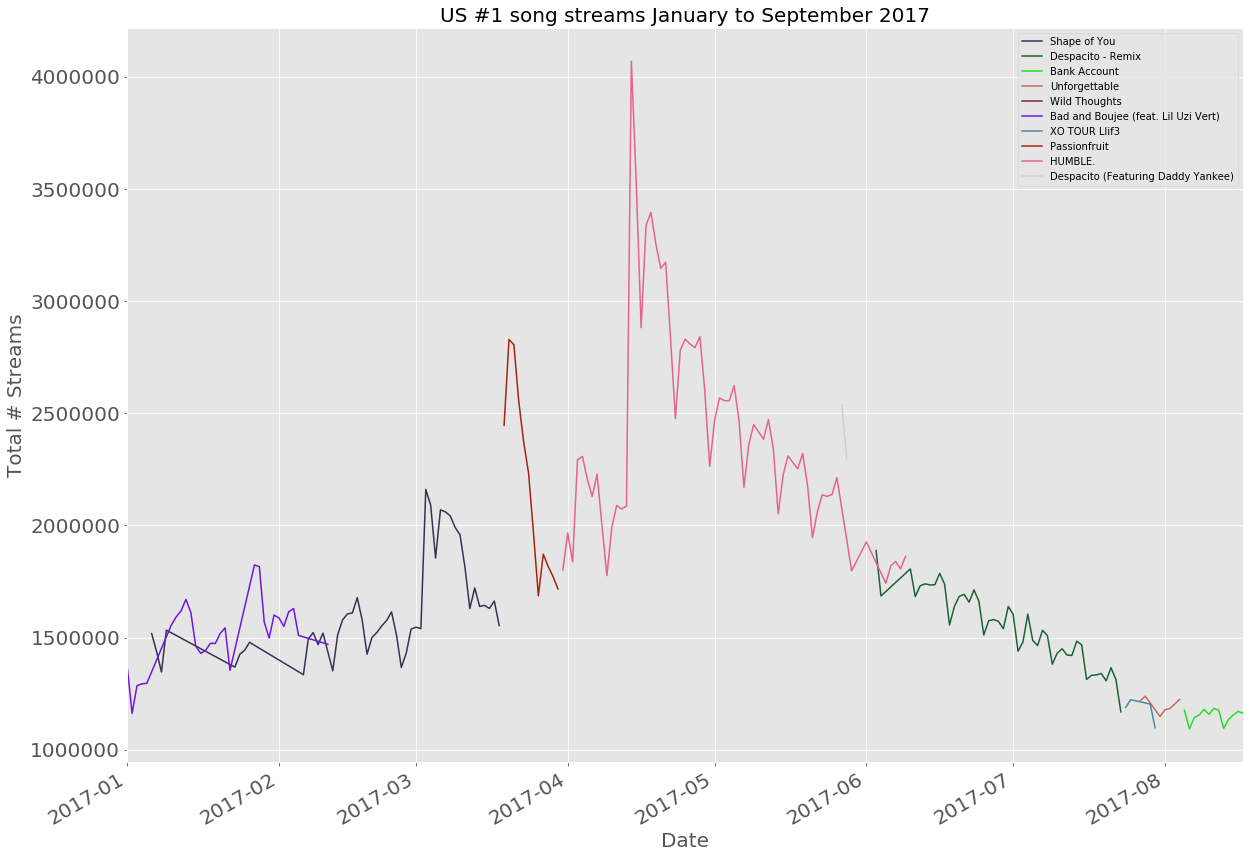

In [35]:
plot_1_song(us_data, 'US #1 song streams January to September 2017')
plt.savefig('../images/US_#1_Song_Streams_January_to_September_2017.png')

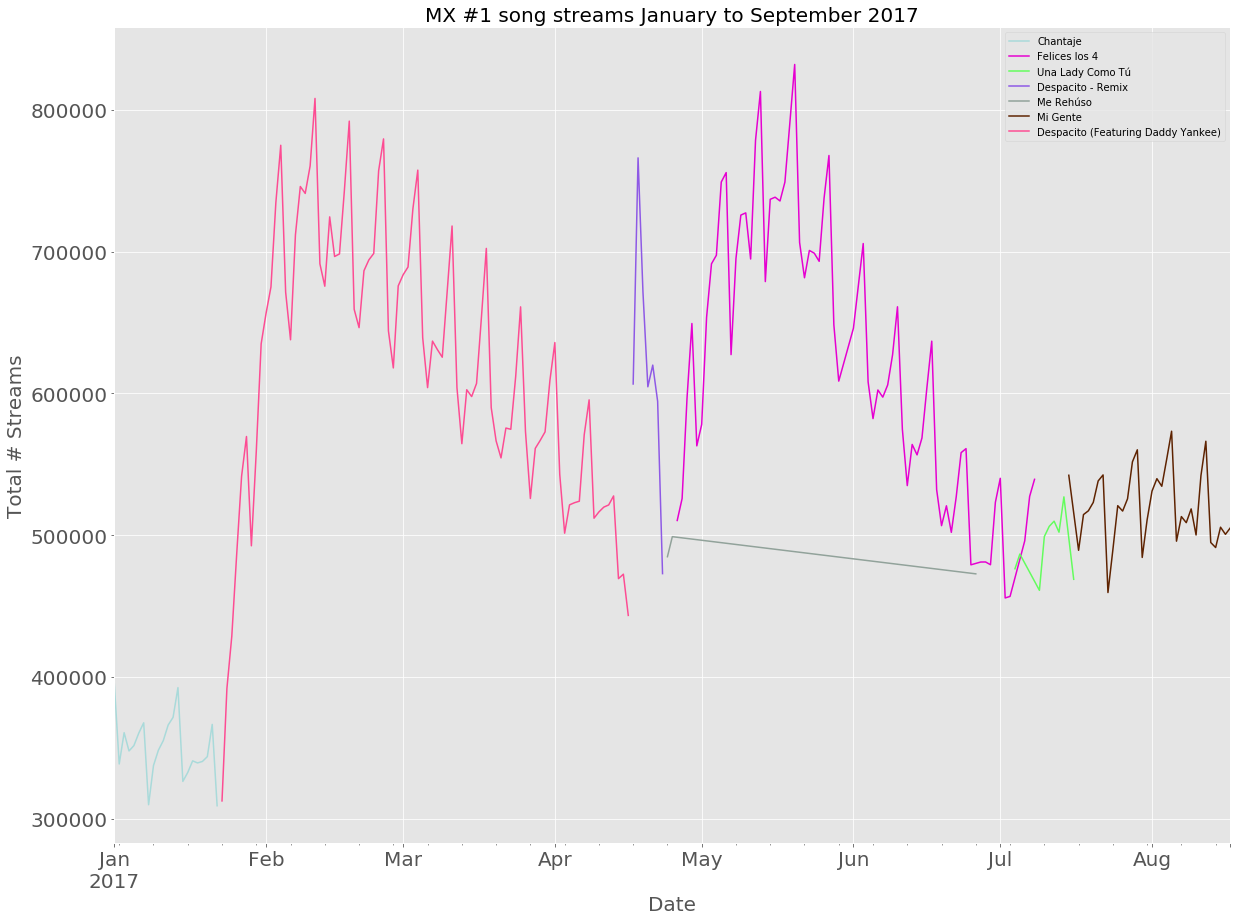

In [23]:
mx_data = get_me_this_region(streaming_data, 'Region', 'mx')
plot_1_song(mx_data, 'MX #1 song streams January to September 2017')

# Creating Stationary TimeSeries Data

In [24]:
timeseries_data = global_streaming_data.set_index('Date')
timeseries_data.head()

index  Region  Streams_#1_song      Artist Track Name  \
Date                                                                 
2017-01-01  822764  global          3135625  The Weeknd    Starboy   
2017-01-02  822964  global          3342769  The Weeknd    Starboy   
2017-01-03  823164  global          3563076  The Weeknd    Starboy   
2017-01-04  823364  global          3619247  The Weeknd    Starboy   
2017-01-05  823564  global          3579206  The Weeknd    Starboy   

            day_of_week        day  avg_streams  
Date                                             
2017-01-01            6     Sunday   743065.835  
2017-01-02            0     Monday   774054.180  
2017-01-03            1    Tuesday   831199.650  
2017-01-04            2  Wednesday   846262.535  
2017-01-05            3   Thursday   849595.470

In [25]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, std=True):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    fig, ax = plt.subplots()
    orig = ax.plot(timeseries, color='orange',label='Original')
    mean = ax.plot(rolmean, color='black', label='Rolling Mean')
    if std:
        std = ax.plot(rolstd, color='red', label = 'Rolling Std')
    fig.set_size_inches((20,10))
    plt.xlabel('Date')
    plt.ylabel('Log Avg # Streams')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    bigger_fonts(ax)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return rolmean

## Avg Streams

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -2.153572
p-value                          0.223525
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


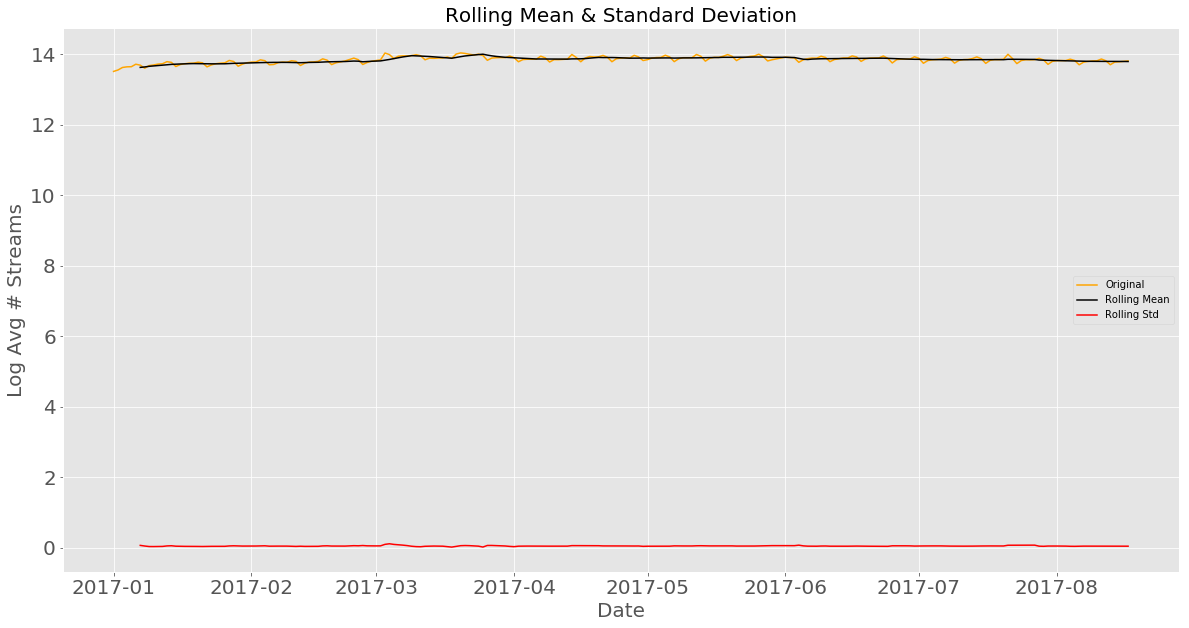

In [26]:
avg_streams_log = np.log(timeseries_data['avg_streams'])
avg_streams_rolmean = test_stationarity(avg_streams_log)

In [27]:
avg_streams_rolmean = test_stationarity(avg_streams_log, std=False)

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -2.153572
p-value                          0.223525
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


### Time Series is not Stationary because Test Stat (-2.15) > Critical Values (10%)

In [28]:
print(avg_streams_log.iloc[30], '-', avg_streams_rolmean.iloc[30], '= avg_streams_mean_diff')
avg_streams_mean_diff = avg_streams_log - avg_streams_rolmean
avg_streams_mean_diff.head(30)

13.7652268801 - 13.7575289608 = avg_streams_mean_diff


Date
2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
2017-01-04         NaN
2017-01-05         NaN
2017-01-06         NaN
2017-01-07    0.063803
2017-01-08   -0.035882
2017-01-09    0.019831
2017-01-10    0.028029
2017-01-11    0.041717
2017-01-12    0.039623
2017-01-13    0.088566
2017-01-14    0.057039
2017-01-15   -0.067442
2017-01-16   -0.015751
2017-01-17    0.001954
2017-01-18    0.012856
2017-01-19    0.012869
2017-01-20    0.042384
2017-01-21    0.026021
2017-01-22   -0.087718
2017-01-23   -0.029639
2017-01-24    0.003551
2017-01-25    0.018409
2017-01-26    0.027158
2017-01-27    0.087738
2017-01-28    0.052187
2017-01-29   -0.083691
2017-01-30   -0.027536
Name: avg_streams, dtype: float64

In [29]:
avg_streams_mean_diff.dropna(inplace=True)
stationary_avg_streams_rolmean = test_stationarity(avg_streams_mean_diff)
plt.savefig('../images/Rolling_Mean_avg_streams_mean_diff.png')

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                -6.571198e+00
p-value                        7.928175e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -2.153572
p-value                          0.223525
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


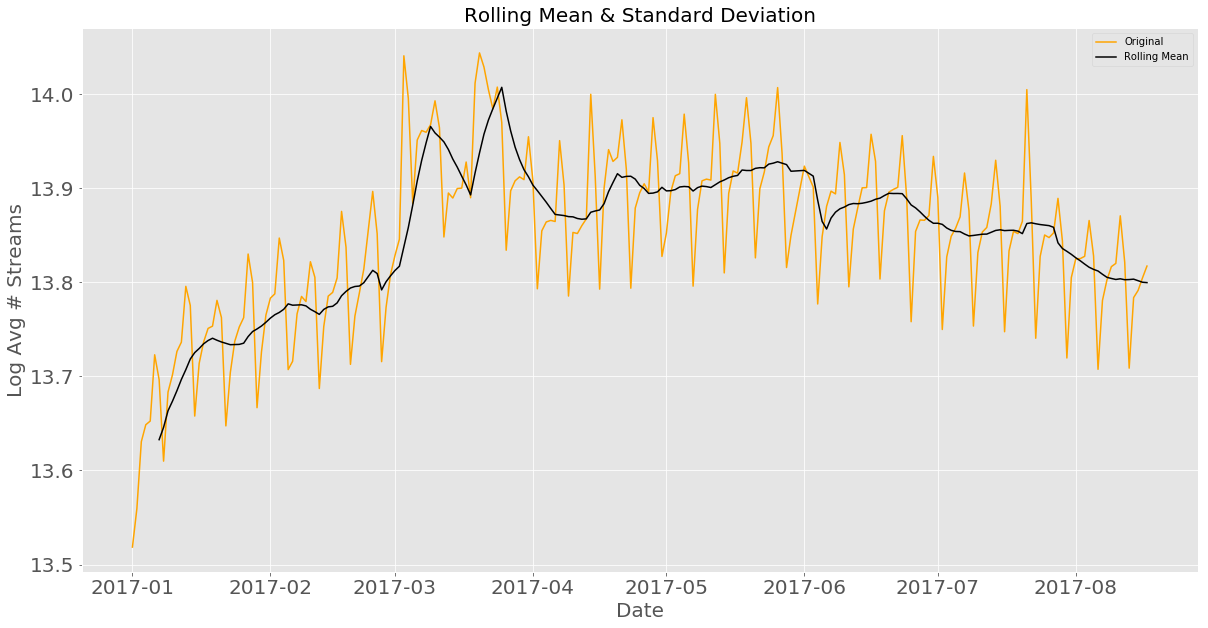

In [30]:
avg_streams_rolmean = test_stationarity(avg_streams_log, std=False)

### Time Series is Stationary with Confidence of 95% because Test Stat (-2.90) < -2.88

## #1 Song Streams

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -0.828937
p-value                          0.810474
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


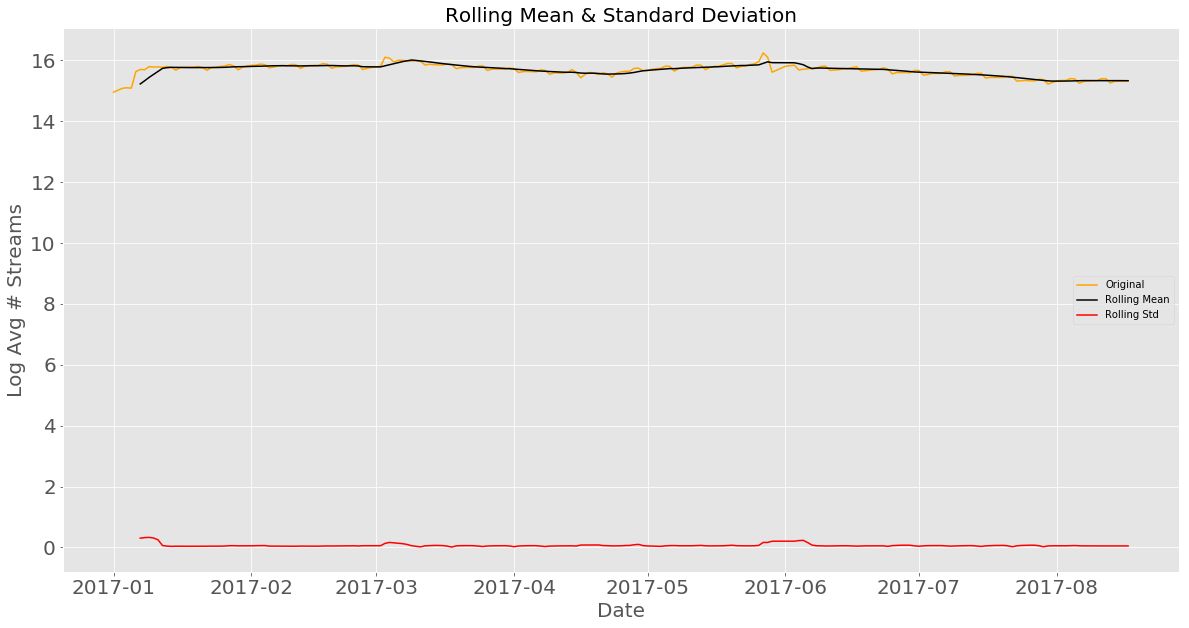

In [31]:
top_streams_log = np.log(timeseries_data['Streams_#1_song'])
top_streams_rolmean = test_stationarity(top_streams_log)

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -0.828937
p-value                          0.810474
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


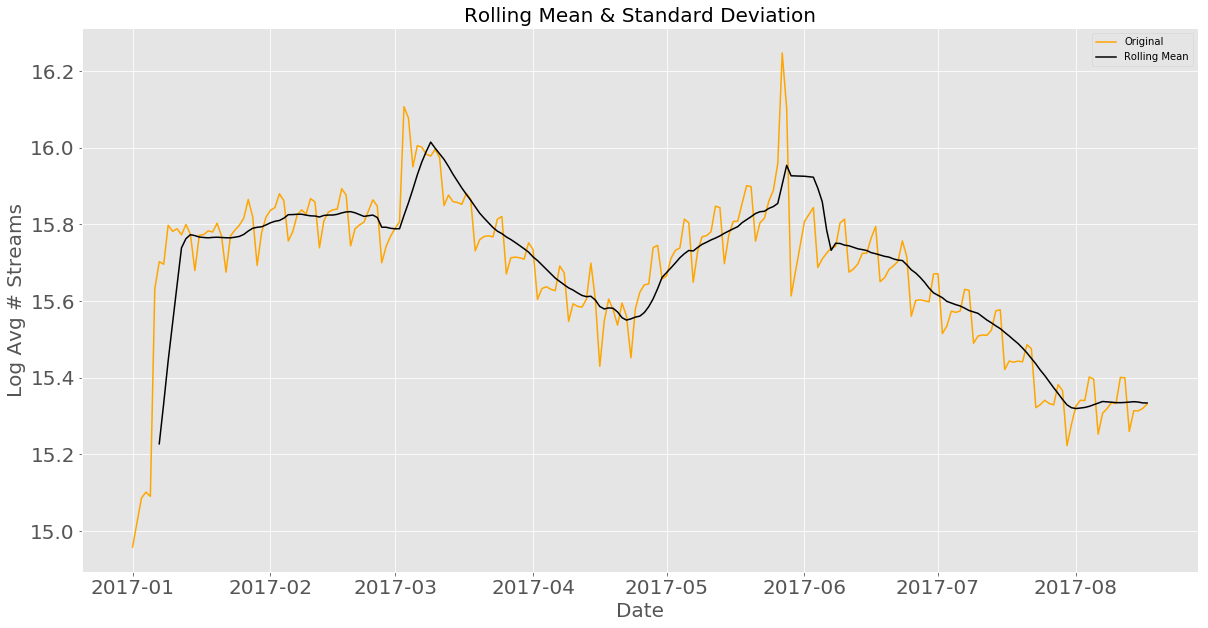

In [32]:
top_streams_rolmean = test_stationarity(top_streams_log, std=False)

### Time Series is not Stationary because Test Stat (-0.82) > Critical Values (10%)

In [33]:
print(top_streams_log.iloc[30], '-', top_streams_rolmean.iloc[30], '= top_streams_mean_diff')
top_streams_mean_diff = top_streams_log - top_streams_rolmean
top_streams_mean_diff.head(30)

15.819609558 - 15.7988050356 = top_streams_mean_diff


Date
2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
2017-01-04         NaN
2017-01-05         NaN
2017-01-06         NaN
2017-01-07    0.475194
2017-01-08    0.362962
2017-01-09    0.354050
2017-01-10    0.238636
2017-01-11    0.147217
2017-01-12    0.034001
2017-01-13    0.037086
2017-01-14    0.001488
2017-01-15   -0.091049
2017-01-16    0.004453
2017-01-17    0.007745
2017-01-18    0.017996
2017-01-19    0.014072
2017-01-20    0.036616
2017-01-21    0.003613
2017-01-22   -0.089789
2017-01-23    0.004711
2017-01-24    0.018597
2017-01-25    0.029094
2017-01-26    0.042733
2017-01-27    0.082316
2017-01-28    0.030044
2017-01-29   -0.099286
2017-01-30   -0.015074
Name: Streams_#1_song, dtype: float64

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -5.512086
p-value                          0.000002
#Lags Used                       7.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


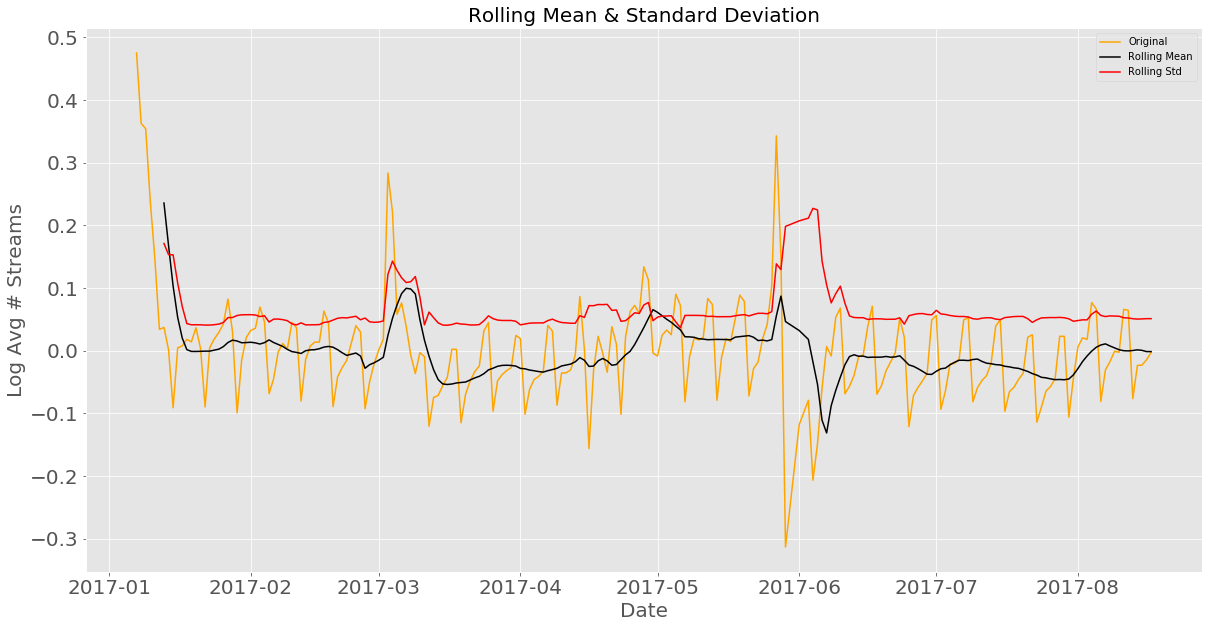

In [34]:
top_streams_mean_diff.dropna(inplace=True)
stationary_top_streams_rolmean = test_stationarity(top_streams_mean_diff)

### Time Series is Stationary with Confidence of 95% because Test Stat (-2.95) < -2.88

# Using Seasonal Decomposition to Increase Stationariness of Data

In [25]:
def seasonal_decomp(ts):
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(x=ts, freq=12)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    fig,ax = plt.subplots(4)
    ax1,ax2,ax3,ax4 = ax

    ax1.plot(ts, label='Original', c='orange')
    ax1.legend(loc='best')

    ax2.plot(trend, label='Trend', c='blue')
    ax2.legend(loc='best')

    ax3.plot(seasonal,label='Seasonality', c='purple')
    ax3.legend(loc='best')

    ax4.plot(residual, label='Residuals',c ='red')
    ax4.legend(loc='best')

    fig.set_size_inches(30,20)
    bigger_fonts(ax1)
    bigger_fonts(ax2)
    bigger_fonts(ax3)
    bigger_fonts(ax4)
    return residual

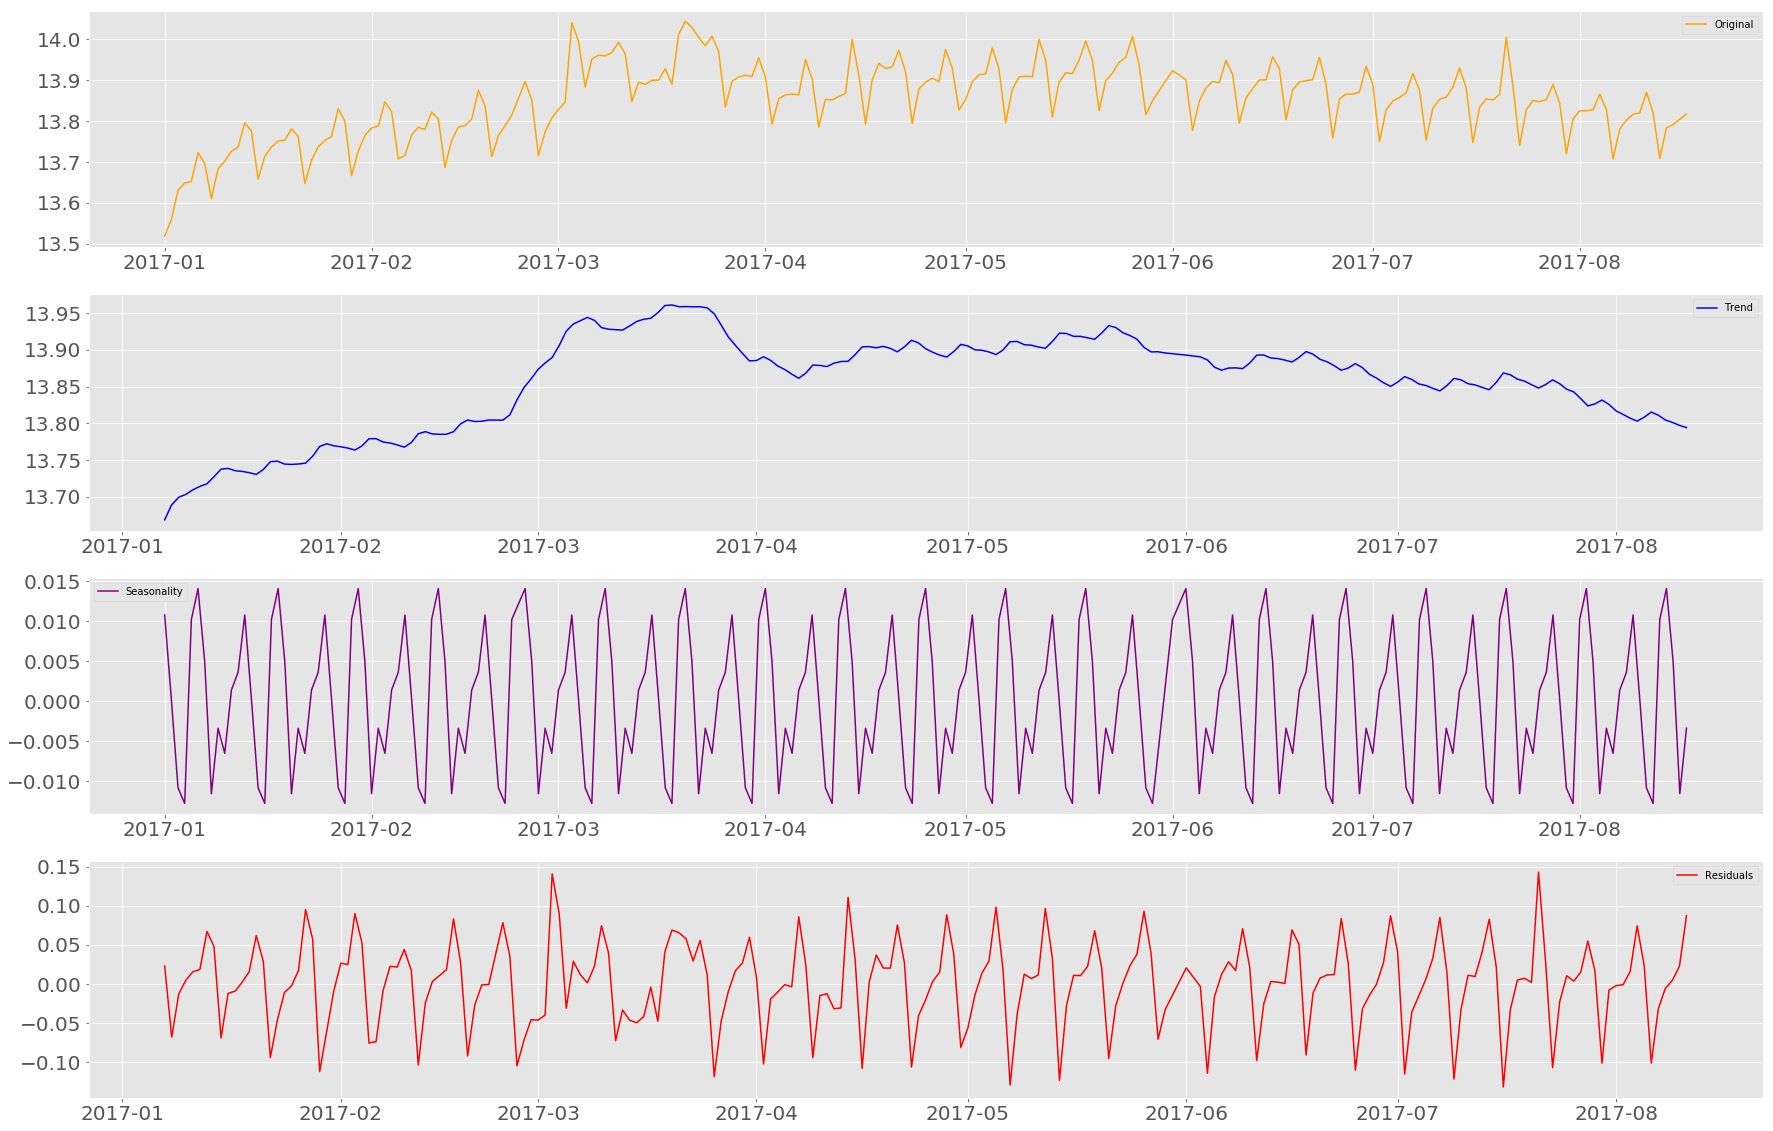

In [26]:
avg_stream_residuals = seasonal_decomp(avg_streams_log)
plt.savefig('../images/Seasonal_Decomp_avg_streams.png')

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                -6.648665e+00
p-value                        5.187399e-09
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


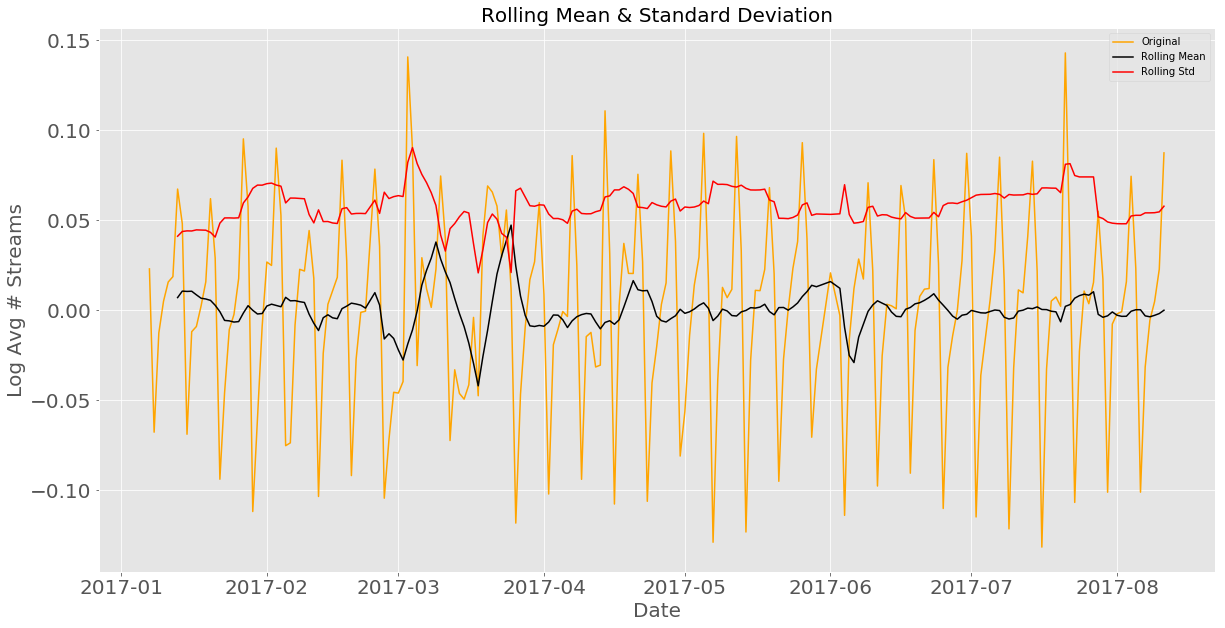

In [27]:
avg_stream_residuals.dropna(inplace=True)
x = test_stationarity(avg_stream_residuals)

### 99% Confidence TS is Stationary --> Test Stat < Critical Val at 1%

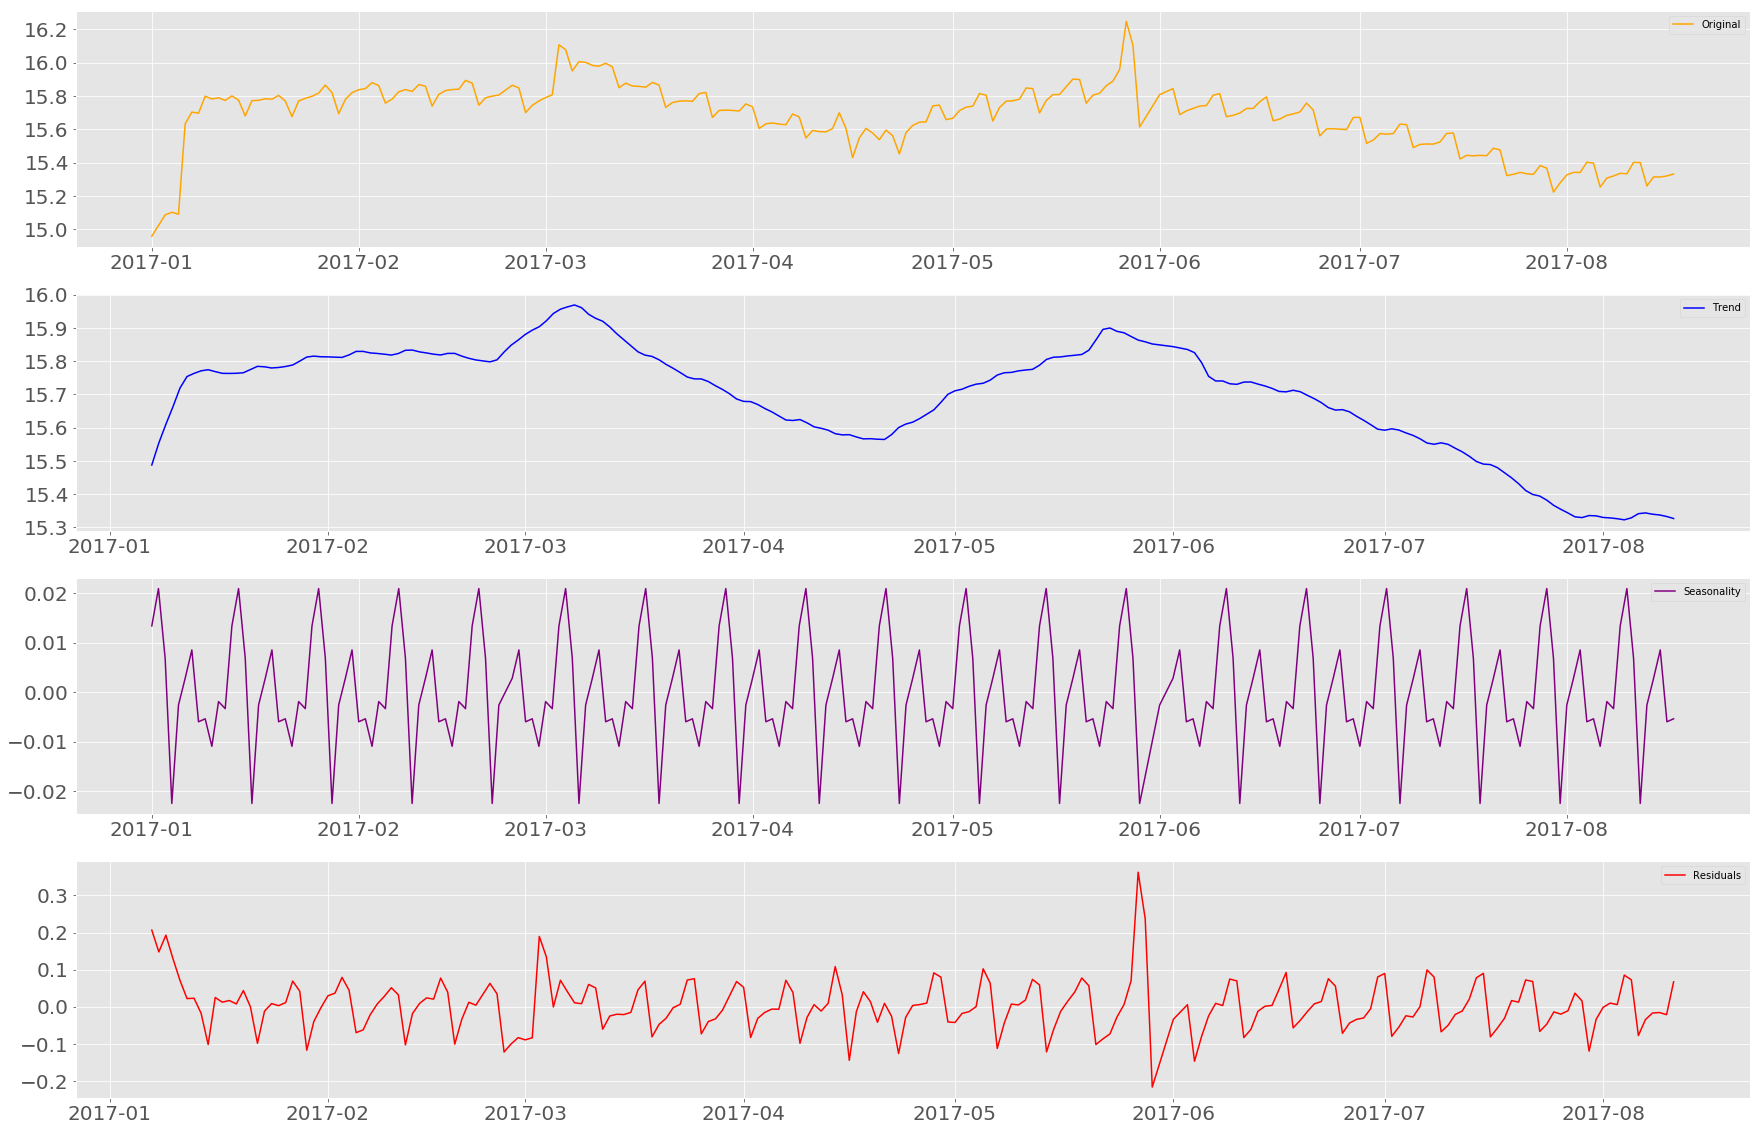

In [28]:
top_song_residuals = seasonal_decomp(top_streams_log)

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                -5.913650e+00
p-value                        2.603312e-07
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


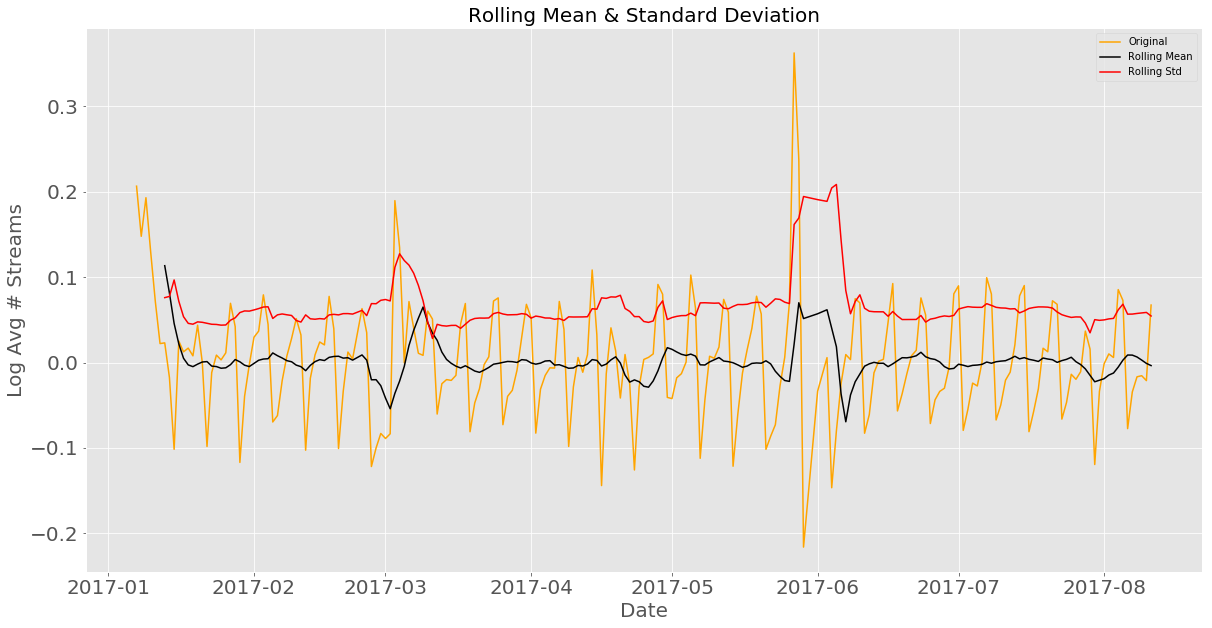

In [29]:
top_song_residuals.dropna(inplace=True)
y = test_stationarity(top_song_residuals)

### 99% Confidence TS is Stationary --> Test Stat < Critical Val at 1%

# ARIMA models

## Average Streams ARIMA model

In [131]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
def ARIMA_model(df, p, q, start=None, end=None, dynamic=False):
    model = ARIMA(df, order=(p, 1, q))  
    results_ARIMA = model.fit(disp=0)
    predictions_ARIMA = results_ARIMA.predict(start, end, dynamic)
    return model, predictions_ARIMA

def transforming_predictions(col_log, ARIMA_predictions):
    predictions_ARIMA_log = pd.Series(col_log.iloc[0], index=col_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(ARIMA_predictions.cumsum(),fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
    return predictions_ARIMA

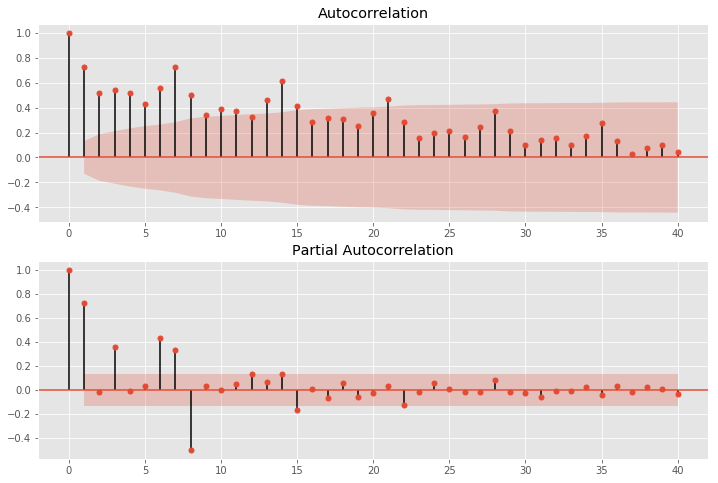

In [81]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(avg_streams_log, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(avg_streams_log, lags=40, ax=ax2)

/Users/gmgtex/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RSS: 0.7770201219379209


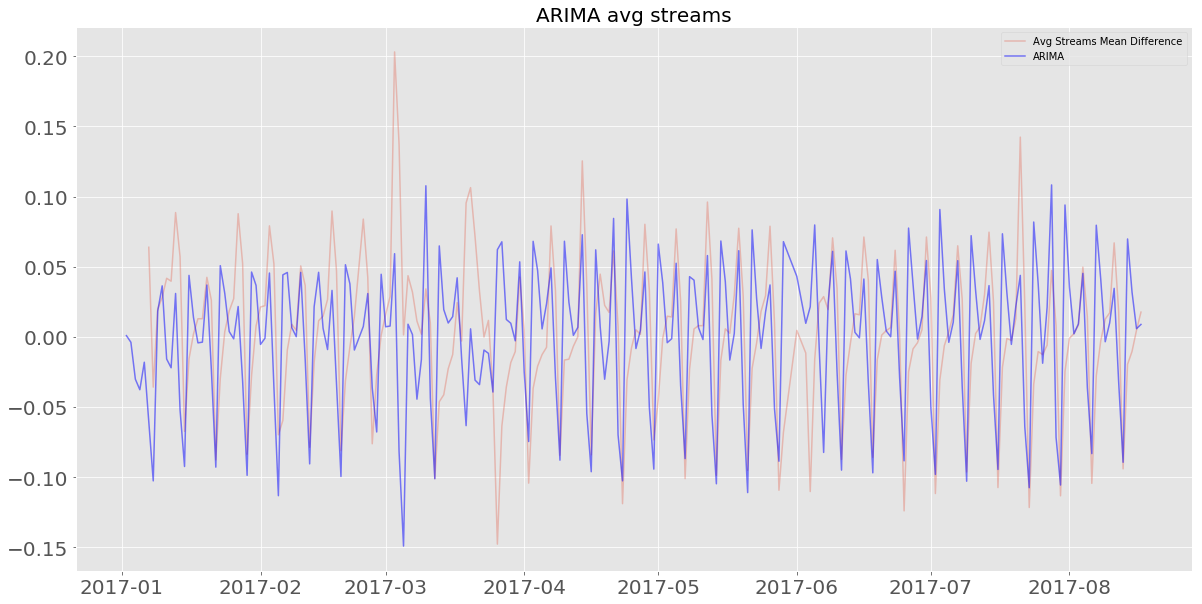

In [82]:
avg_streams_model, avg_streams_predictions_ARIMA = ARIMA_model(avg_streams_log,9,2)

fig, ax = plt.subplots(1)
ax.plot(avg_streams_mean_diff, label='Avg Streams Mean Difference', alpha=0.3)
ax.plot(avg_streams_predictions_ARIMA, color='blue', alpha=0.5, label='ARIMA')
plt.title('ARIMA avg streams')
plt.legend(loc='best')
fig.set_size_inches(20,10)
bigger_fonts(ax)
plt.savefig('../images/ARIMA_model_stationary_avg_streams.png')


print('RSS: {}' .format(((avg_streams_predictions_ARIMA - avg_streams_mean_diff)**2).sum()))

In [83]:
avg_streams_predictions_ARIMA.head()

Date
2017-01-02    0.000821
2017-01-03   -0.003917
2017-01-04   -0.030238
2017-01-05   -0.037743
2017-01-06   -0.018136
dtype: float64

In [84]:
 avg_streams_predictions_ARIMA.cumsum().head(10)

Date
2017-01-02    0.000821
2017-01-03   -0.003095
2017-01-04   -0.033333
2017-01-05   -0.071076
2017-01-06   -0.089212
2017-01-07   -0.149504
2017-01-08   -0.252244
2017-01-09   -0.233977
2017-01-10   -0.197662
2017-01-11   -0.213527
dtype: float64

RMSE: 507247.57


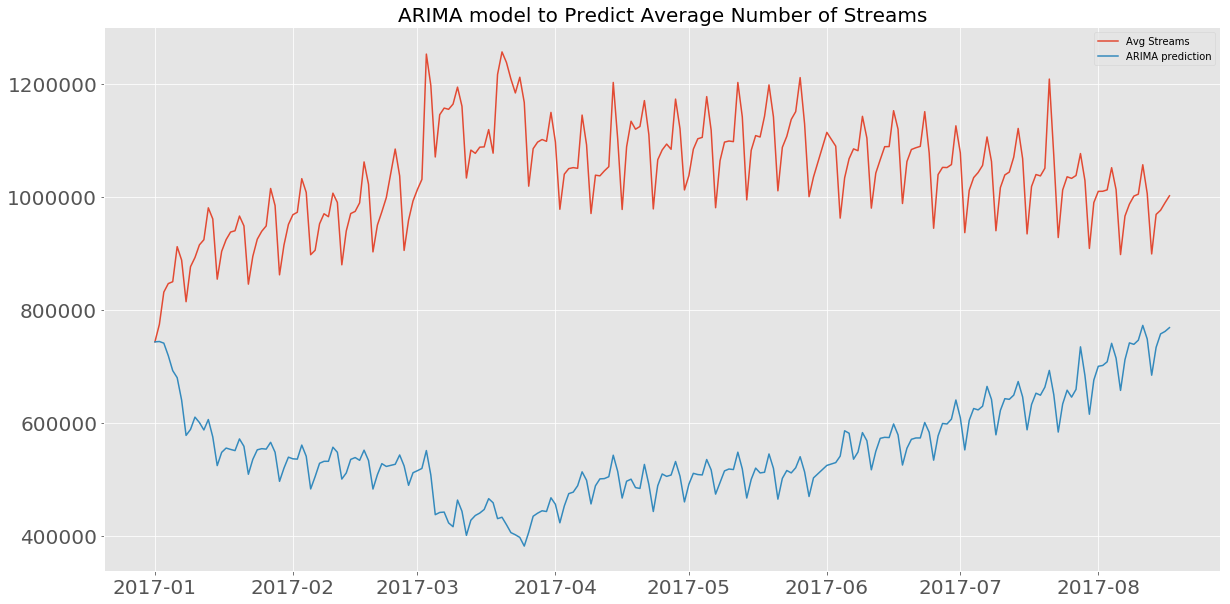

In [85]:
avg_predictions_ARIMA = transforming_predictions(avg_streams_log, avg_streams_predictions_ARIMA)

fig, ax = plt.subplots(1)
ax.plot(timeseries_data['avg_streams'], label='Avg Streams')
ax.plot(avg_predictions_ARIMA, label='ARIMA prediction')
plt.title('ARIMA model to Predict Average Number of Streams')
plt.legend(loc='best')
bigger_fonts(ax)
fig.set_size_inches((20,10))
plt.savefig('../images/ARIMA_model_to_Predict_Average_Number_of_Streams.png')
print('RMSE: %.2f'% np.sqrt(sum((avg_predictions_ARIMA-timeseries_data['avg_streams'])**2)/len(timeseries_data['avg_streams'])))

## Top Streams ARIMA model

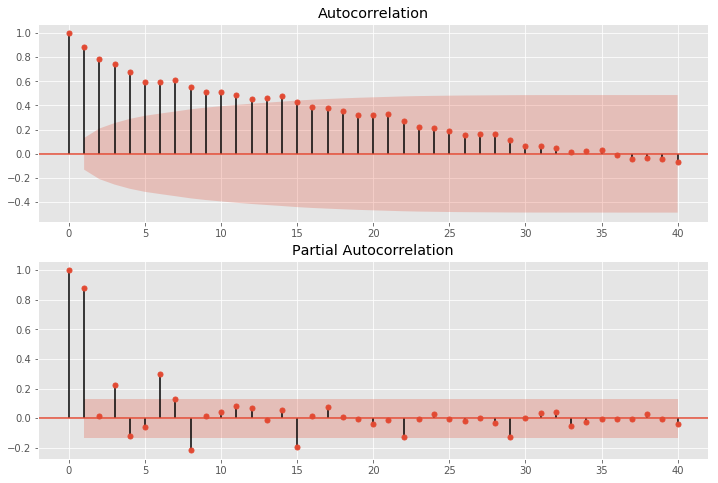

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(top_streams_log, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(top_streams_log, lags=40, ax=ax2)

In [54]:
top_streams_model, top_streams_predictions_ARIMA = ARIMA_model(top_streams_log,15,2)

fig, ax = plt.subplots(1)
ax.plot(top_streams_mean_diff, label='Avg Streams Mean Difference', alpha=0.3)
ax.plot(top_streams_predictions_ARIMA, color='blue', alpha=0.5, label='ARIMA')
plt.title('ARIMA streams of #1 Song')
plt.legend(loc='best')
fig.set_size_inches(20,10)
bigger_fonts(ax)

print('RSS: {}' .format(((top_streams_predictions_ARIMA - top_streams_mean_diff)**2).sum()))

/Users/gmgtex/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RSS: 1.953395645584961


RMSE: 3335203.99


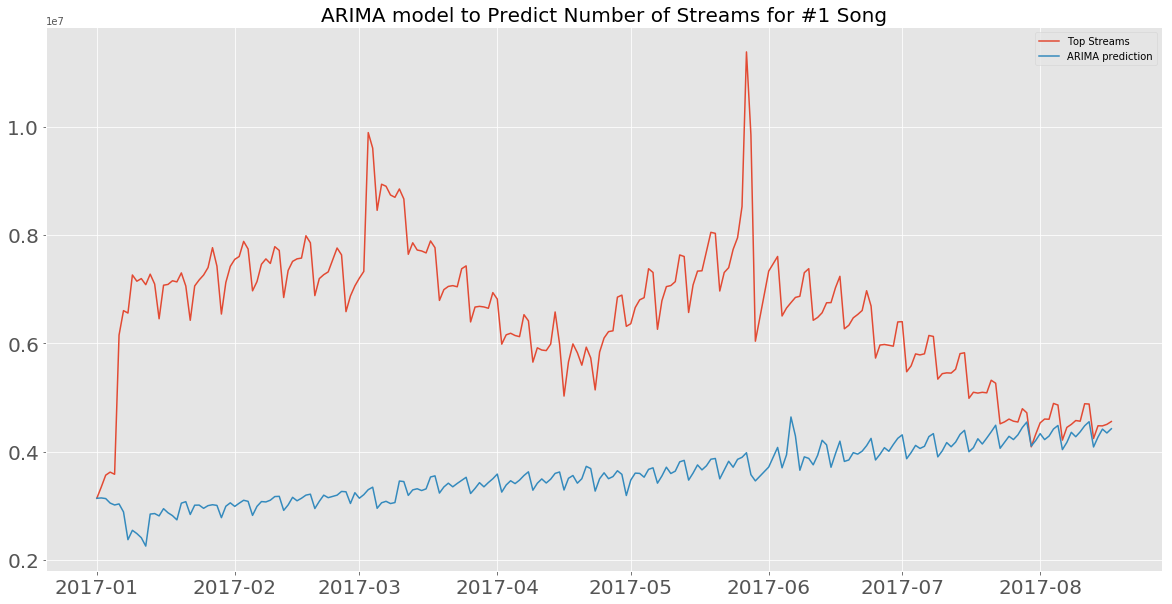

In [55]:
top_streams_predictions = transforming_predictions(top_streams_log, top_streams_predictions_ARIMA)

fig, ax = plt.subplots(1)
ax.plot(timeseries_data['Streams_#1_song'], label='Top Streams')
ax.plot(top_streams_predictions, label='ARIMA prediction')
plt.title('ARIMA model to Predict Number of Streams for #1 Song')
plt.legend(loc='best')
bigger_fonts(ax)
fig.set_size_inches((20,10))
print('RMSE: %.2f'% np.sqrt(sum((top_streams_predictions-timeseries_data['Streams_#1_song'])**2)/len(timeseries_data['Streams_#1_song'])))

## Total Streams ARIMA model

In [46]:
spotify_global_df = spotify_df[spotify_df['Region']=='global']

In [47]:
spotify_total_streams = spotify_global_df.groupby('Date').sum()['Streams'].reset_index()
spotify_total_streams.set_index('Date', inplace=True)

In [48]:
spotify_total_streams_log = np.log(spotify_total_streams['Streams'])
spotify_total_streams_rolmean = test_stationarity(spotify_total_streams_log, std=False)

/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                  -2.153572
p-value                          0.223525
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  """
/Users/gmgtex/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                -6.571198e+00
p-value                        7.928175e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


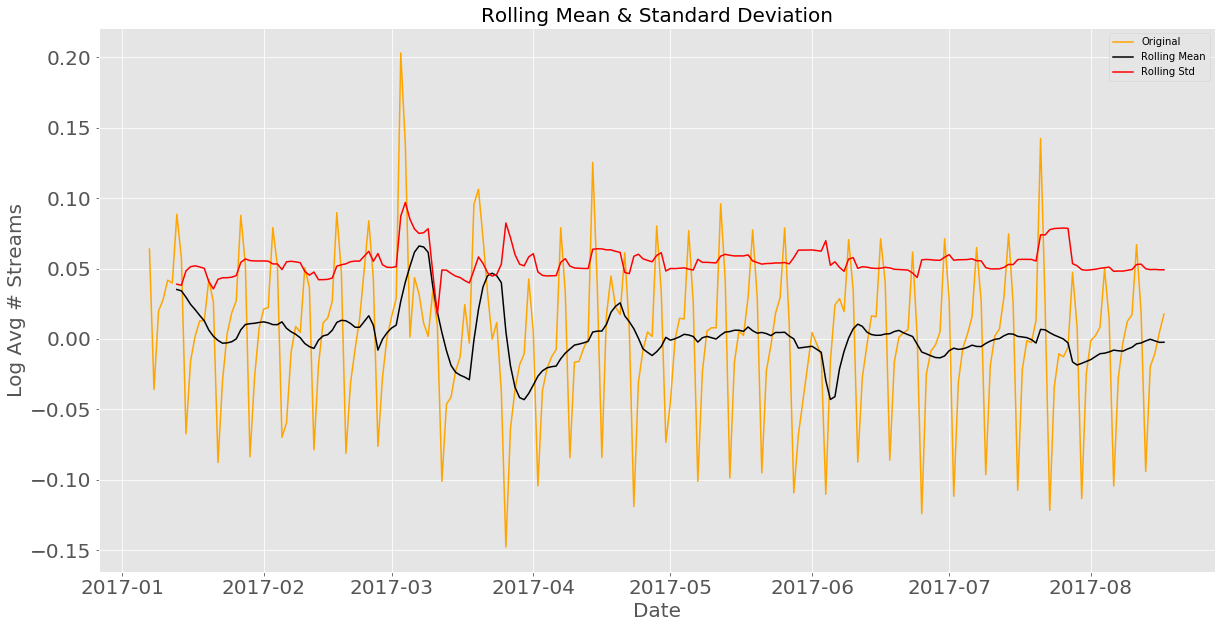

In [49]:
spotify_total_streams_log_mean_diff = spotify_total_streams_log - spotify_total_streams_rolmean
spotify_total_streams_log_mean_diff.dropna(inplace=True)
spotify_total_streams_rolmean = test_stationarity(spotify_total_streams_log_mean_diff)

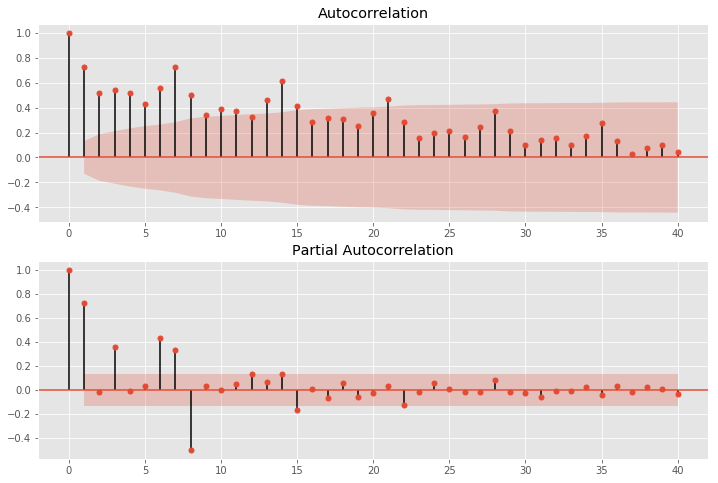

In [68]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(spotify_total_streams_log, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(spotify_total_streams_log, lags=40, ax=ax2)

/Users/gmgtex/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RSS: 0.777412168925998


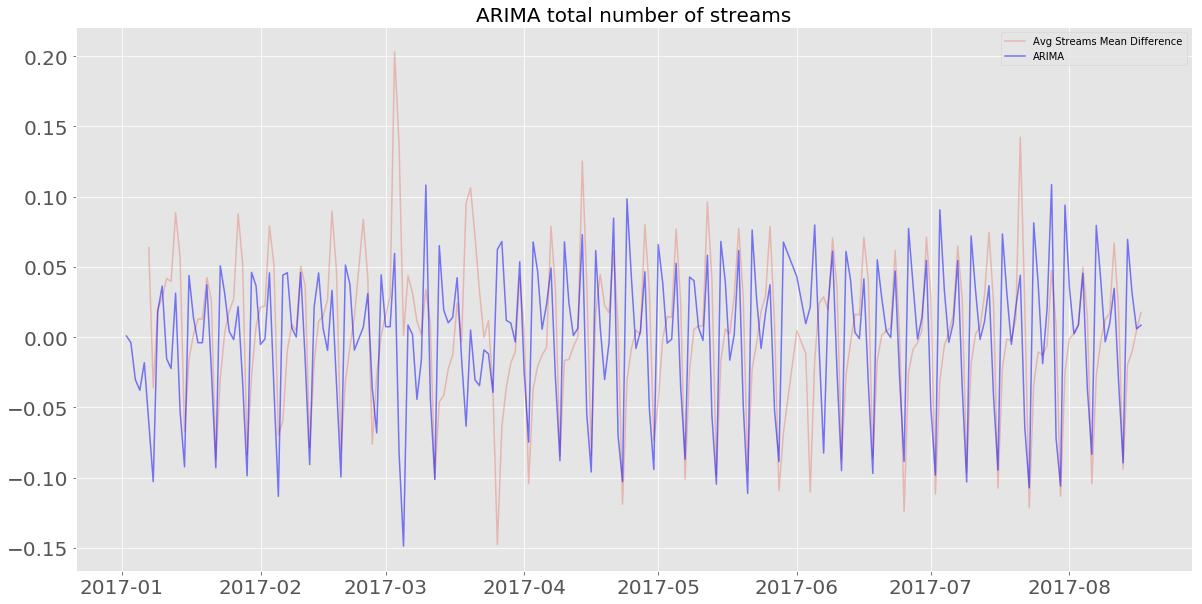

In [69]:
total_streams_model, total_streams_predictions_ARIMA = ARIMA_model(spotify_total_streams_log,9,2)

fig, ax = plt.subplots(1)
ax.plot(spotify_total_streams_log_mean_diff, label='Avg Streams Mean Difference', alpha=0.3)
ax.plot(total_streams_predictions_ARIMA, color='blue', alpha=0.5, label='ARIMA')
plt.title('ARIMA total number of streams')
plt.legend(loc='best')
fig.set_size_inches(20,10)
bigger_fonts(ax)

print('RSS: {}' .format(((total_streams_predictions_ARIMA - spotify_total_streams_log_mean_diff)**2).sum()))

In [70]:
total_streams_predictions = transforming_predictions(spotify_total_streams_log, total_streams_predictions_ARIMA)

fig, ax = plt.subplots(1)
ax.plot(spotify_total_streams['Streams'], label='Total Streams')
ax.plot(total_streams_predictions, label='ARIMA prediction')
plt.title('ARIMA model to Predict Total Number of Spotify Streams')
plt.legend(loc='best')
bigger_fonts(ax)
fig.set_size_inches((20,10))
print('RMSE: %.2f'% np.sqrt(sum((total_streams_predictions-spotify_total_streams['Streams'])**2)/len(spotify_total_streams['Streams'])))

RMSE: 101768034.36


# Conclusions & Future Directions
We can see that ARIMA models are able to capture the weekly trends in number of daily Spotify streams. Number of daily streams are lowest on Sundays and grow gradually throughout the week, peaking on Fridays.  
However, the ARIMA models not very good at forecasting monthly trends of daily number of Spotify streams. Since, this data is only for an 8 month period, the ARIMA models are having a tough time forecasting the monthly underlying signal. A longer period of data would allow the ARIMA models to better capture this signal.  
Some future directions for this project would be to try LSTM neural net to improve the predictions of number of daily streams on Spotify.